In [358]:
#horizontal_stack.to_csv('latlong_final.csv',index=False)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import requests
import pandas as pd
import lxml
from slugify import slugify
import html5lib
import bs4
from pandas import DataFrame
import sys

In [ ]:
#Set Headers for request to the website 
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
#URL from where the tables will be scraped
count = 0
for i in range(len(data_list)):
    data = data_list[i].replace(" ", "_")
    try:
        url='https://wiki.openstreetmap.org/wiki/Districts_in_'+data
        print(url)


    #Fetch the page at the url using "requests" module
        r = requests.get(url, headers=header)

        #Read all tables in the response into a list of dataframes
        dataframes=pd.read_html(r.text, header=0)

    #     #Iterate through the data frames to access each table
    #     for dataframe in dataframes:
        df = pd.DataFrame(dataframes)
        data_district = df[0][0]
        count += 1
        data_district.to_csv(data+"_district.csv", sep='\t')
        
    except Exception as inst:
        print("err")
        continue

In [ ]:
# merge all csv files using the command line
# cat *.csv > merged.csv

In [409]:
df = pd.read_csv("merged.csv",error_bad_lines=False,sep="\t")
df.drop(columns=["Unnamed: 0","Code","Relation","Wikidata","Notes"],inplace=True)

b'Skipping line 43: expected 8 fields, saw 9\nSkipping line 44: expected 8 fields, saw 9\nSkipping line 45: expected 8 fields, saw 9\nSkipping line 46: expected 8 fields, saw 9\nSkipping line 47: expected 8 fields, saw 9\nSkipping line 48: expected 8 fields, saw 9\nSkipping line 49: expected 8 fields, saw 9\nSkipping line 50: expected 8 fields, saw 9\nSkipping line 51: expected 8 fields, saw 9\nSkipping line 52: expected 8 fields, saw 9\nSkipping line 53: expected 8 fields, saw 9\nSkipping line 54: expected 8 fields, saw 9\nSkipping line 55: expected 8 fields, saw 9\nSkipping line 56: expected 8 fields, saw 9\nSkipping line 57: expected 8 fields, saw 9\nSkipping line 58: expected 8 fields, saw 9\nSkipping line 59: expected 8 fields, saw 9\nSkipping line 60: expected 8 fields, saw 9\nSkipping line 61: expected 8 fields, saw 9\nSkipping line 62: expected 8 fields, saw 9\nSkipping line 63: expected 8 fields, saw 9\nSkipping line 64: expected 8 fields, saw 9\nSkipping line 65: expected 8 f

In [410]:
df

,District,area official(km²),area OSM (km²)
0,Anantapur,19130,19030
1,Chittoor,15152,14985
2,East Godavari,12805,12679
3,Guntur,11391,11441
4,YSR Kadapa,15379,15104
...,...,...,...
761,Purba Medinipur,"3,952?",NaN
762,Purulia,6258,NaN
763,South 24 Parganas,"7,474?",NaN
764,Uttar Dinajpur,3195,NaN


In [417]:
# Remove ? from the column "area official"
patternDel = "\w*\?[^\s]*"
filter = df['area official(km²)'].str.contains(patternDel,na=False)

In [419]:
df = df[~filter]
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,District,area official(km²),area OSM (km²)
0,Anantapur,19130,19030
1,Chittoor,15152,14985
2,East Godavari,12805,12679
3,Guntur,11391,11441
4,YSR Kadapa,15379,15104
...,...,...,...
759,North 24 Parganas,3964,NaN
760,Paschim Medinipur,6244,NaN
762,Purulia,6258,NaN
764,Uttar Dinajpur,3195,NaN


In [420]:
df.drop(columns="area OSM (km²)",inplace=True)

In [421]:
df

,District,area official(km²)
0,Anantapur,19130
1,Chittoor,15152
2,East Godavari,12805
3,Guntur,11391
4,YSR Kadapa,15379
...,...,...
759,North 24 Parganas,3964
760,Paschim Medinipur,6244
762,Purulia,6258
764,Uttar Dinajpur,3195


In [422]:
df_new = df[df['area official(km²)'].notnull()]

In [423]:
df_new

,District,area official(km²)
0,Anantapur,19130
1,Chittoor,15152
2,East Godavari,12805
3,Guntur,11391
4,YSR Kadapa,15379
...,...,...
759,North 24 Parganas,3964
760,Paschim Medinipur,6244
762,Purulia,6258
764,Uttar Dinajpur,3195


In [403]:
# Reverse Geocoding to get the Latitude, Longitude of Districts
from geopy.geocoders import Nominatim
geolocator = Nominatim()
import numpy as np

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [424]:
def geolocate(city=None, country='India'):
    '''
    Inputs city and country, or just country. Returns the lat/long coordinates of 
    either the city if possible, if not, then returns lat/long of the center of the country.
    '''
    
    # If the city exists,
    if city != None:
        # Try
        try:
            # To geolocate the city and country
            loc = geolocator.geocode(str(city + ',' + country))
            # And return latitude and longitude
            return (loc.latitude, loc.longitude)
        # Otherwise
        except:
            # Return missing value
            return np.nan
    # If the city doesn't exist
    else:
        # Try
        try:
            # Geolocate the center of the country
            loc = geolocator.geocode(country)
            # And return latitude and longitude 
            return (loc.latitude, loc.longitude)
        # Otherwise
        except:
            # Return missing value
            return np.nan

In [ ]:
district_df = []
for index, row in df_new.iterrows():
    lat_long = geolocate(city=row['District'])
    district_df.append(lat_long)

In [ ]:
dfObj = pd.DataFrame(district_df,columns=["Latlong"]) 
dfObj.to_csv('latlong_test.csv',index=False)

In [ ]:
# replace bracket
read_lalon['Latlong'] =  read_lalon['Latlong'].astype(str).apply(lambda x: x.replace('(','').replace(')','')) 

In [ ]:

horizontal_stack = pd.concat([df_final, p], axis=1)
horizontal_stack.drop(columns="Unnamed: 0",inplace=True)

In [ ]:
horizontal_stack['Density']=horizontal_stack['Population']/horizontal_stack['area official(km²)']

In [397]:
df_final_geo_test = gpd.read_file("latlong_final.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

In [399]:
def custom_div_cmap(numcolors=5, name='custom_div_cmap',
                    col1='yellowgreen',col2='gold',col3='orange',col4='red', col5='darkred'):
        """ Create a custom diverging colormap with seven colors """

        from matplotlib.colors import LinearSegmentedColormap 

        cmap = LinearSegmentedColormap.from_list(name=name, 
                                        colors =[col1, col2, col3, col4, col5],
                                            N=numcolors)
        return cmap

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


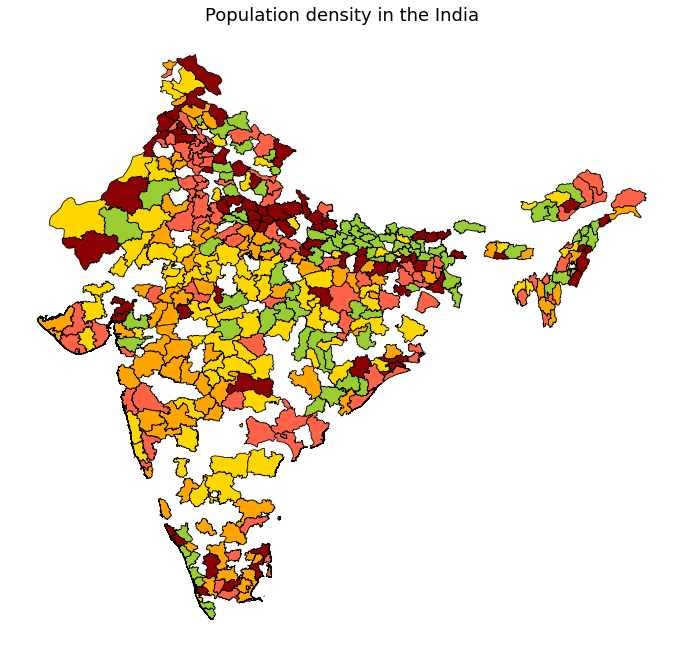

In [402]:
import matplotlib.pyplot as plt           # for plotting
%matplotlib inline

fig, ax = plt.subplots(1, 1)                  # initializing a figure
fig.set_size_inches(12,12)                      # setting the size

cmap=custom_div_cmap(5, col1='yellowgreen',col2='gold',col3='orange',col4='tomato', col5='darkred')  


df_final_geo_test.plot(column='Density', cmap = cmap, ax=ax,linewidth=0.8,scheme = "quantiles",edgecolor='black',missing_kwds={'color': 'lightgrey'})


ax.axis('off')
ax.set_title('Population density in the India', fontsize=18)
fig.savefig('Population_IN.png', dpi=300)
plt.show()